In [2]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch

In [3]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [4]:
A = 1.2
b = -0.3
sigma = 0.2
N = 100

In [5]:
np.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [6]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()

In [7]:
y = A*X + b + e

In [8]:
y.detach()
y = y.float()

In [9]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [10]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [11]:
def log_q_pdf(w, theta):
    (mu_A, mu_b, rho_A, rho_b) = theta 
    
    sigma_A = rho_to_sigma(rho_A)
    qA = torch.distributions.normal.Normal(mu_A, sigma_A)
    
    sigma_b = rho_to_sigma(rho_b)
    qb = torch.distributions.normal.Normal(mu_b, sigma_b)
    
    lp = qA.log_prob(w[0]) + qb.log_prob(w[1])
    return lp

In [12]:
def log_p_pdf(w):
    prior_mu_A = torch.tensor(0.0) 
    prior_sigma_A = torch.tensor(1.0)
    pA = torch.distributions.normal.Normal(prior_mu_A, prior_sigma_A)
    
    prior_mu_b = torch.tensor(0.0) 
    prior_sigma_b = torch.tensor(1.0)
    pb = torch.distributions.normal.Normal(prior_mu_b, prior_sigma_b)
    
    lp = pA.log_prob(w[0]) + pb.log_prob(w[1])
    return lp

In [13]:
def likelihood(y,X,w):
    A = w[0]
    b = w[1]
    
    y_pred = A*X + b
    lp = torch.distributions.normal.Normal(y_pred, 0.2).log_prob(y).sum()
    return lp

In [14]:
def f(w, theta):
    v = log_q_pdf(w, theta) - log_p_pdf(w) - likelihood(y,X,w)
    return v

In [15]:
mu_A = torch.tensor(0.0)
sigma_A = torch.tensor(0.1)
rho_A = sigma_to_rho(sigma_A)
mu_b = torch.tensor(0.0)
sigma_b = torch.tensor(0.1)
rho_b = sigma_to_rho(sigma_b)

theta = torch.tensor([mu_A, mu_b, rho_A, rho_b], requires_grad=True)

In [16]:
alpha = torch.tensor(10e-5)

In [17]:
for i in range(0,10000):
    lst_grad_mu = []
    lst_grad_rho = []
    lst_v = []
    for j in range(0,20):
        epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

        with torch.no_grad():
            w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
        w.requires_grad = True

        v = f(w, theta)   
        v.backward()
        lst_v.append(v.data)
        v = torch.tensor([])

        with torch.no_grad():
            grad_mu = w.grad + theta.grad[0:2]
            grad_rho = w.grad*epsilon/(1 + torch.exp(-theta[2:4])) + -theta.grad[2:4]


        lst_grad_mu.append(grad_mu)
        lst_grad_rho.append(grad_rho)

        theta.grad.zero_()
        w.grad.zero_()
        v.detach()
    grad_mu = torch.stack(lst_grad_mu).mean(dim=0)
    grad_rho = torch.stack(lst_grad_rho).mean(dim=0)
    
    print(torch.stack(lst_v).mean())
    #print(grad_mu)
    #print(grad_rho)
        
    with torch.no_grad():
        theta[0:2] -= alpha*grad_mu
        theta[2:4] -= alpha*grad_rho
    
    print(theta)



tensor(292.2523)
tensor([ 0.0655,  0.0854, -2.2538, -2.2558], requires_grad=True)
tensor(154.9870)
tensor([ 0.1063,  0.1244, -2.2526, -2.2584], requires_grad=True)
tensor(131.0244)
tensor([ 0.1414,  0.1516, -2.2530, -2.2594], requires_grad=True)
tensor(117.0878)
tensor([ 0.1740,  0.1742, -2.2535, -2.2604], requires_grad=True)
tensor(99.4980)
tensor([ 0.1962,  0.1778, -2.2536, -2.2622], requires_grad=True)
tensor(102.9588)
tensor([ 0.2228,  0.1904, -2.2547, -2.2635], requires_grad=True)
tensor(91.1572)
tensor([ 0.2397,  0.1853, -2.2544, -2.2664], requires_grad=True)
tensor(97.9648)
tensor([ 0.2632,  0.1944, -2.2551, -2.2696], requires_grad=True)
tensor(99.0987)
tensor([ 0.2809,  0.1917, -2.2565, -2.2731], requires_grad=True)
tensor(89.6954)
tensor([ 0.3013,  0.1941, -2.2573, -2.2755], requires_grad=True)
tensor(70.4221)
tensor([ 0.3151,  0.1863, -2.2571, -2.2770], requires_grad=True)
tensor(73.5818)
tensor([ 0.3266,  0.1739, -2.2574, -2.2787], requires_grad=True)
tensor(84.5712)
tensor(

tensor(-4.0638)
tensor([ 1.0116, -0.1646, -2.3169, -2.4590], requires_grad=True)
tensor(-4.7923)
tensor([ 1.0133, -0.1685, -2.3174, -2.4597], requires_grad=True)
tensor(3.3072)
tensor([ 1.0198, -0.1622, -2.3182, -2.4617], requires_grad=True)
tensor(2.8143)
tensor([ 1.0221, -0.1649, -2.3189, -2.4636], requires_grad=True)
tensor(-0.4119)
tensor([ 1.0255, -0.1655, -2.3192, -2.4653], requires_grad=True)
tensor(-1.5325)
tensor([ 1.0280, -0.1655, -2.3197, -2.4667], requires_grad=True)
tensor(0.8107)
tensor([ 1.0273, -0.1747, -2.3203, -2.4682], requires_grad=True)
tensor(-1.7154)
tensor([ 1.0324, -0.1710, -2.3212, -2.4692], requires_grad=True)
tensor(1.7897)
tensor([ 1.0335, -0.1758, -2.3219, -2.4708], requires_grad=True)
tensor(2.0229)
tensor([ 1.0342, -0.1796, -2.3226, -2.4728], requires_grad=True)
tensor(-0.4010)
tensor([ 1.0371, -0.1811, -2.3232, -2.4743], requires_grad=True)
tensor(-2.7531)
tensor([ 1.0367, -0.1886, -2.3237, -2.4755], requires_grad=True)
tensor(-0.9002)
tensor([ 1.0370, 

tensor([ 1.1487, -0.2448, -2.3723, -2.5982], requires_grad=True)
tensor(-0.2401)
tensor([ 1.1465, -0.2502, -2.3731, -2.6000], requires_grad=True)
tensor(-5.2526)
tensor([ 1.1494, -0.2472, -2.3738, -2.6009], requires_grad=True)
tensor(-1.6842)
tensor([ 1.1574, -0.2345, -2.3746, -2.6021], requires_grad=True)
tensor(-6.8495)
tensor([ 1.1534, -0.2433, -2.3751, -2.6029], requires_grad=True)
tensor(-8.9843)
tensor([ 1.1556, -0.2397, -2.3755, -2.6034], requires_grad=True)
tensor(-5.9640)
tensor([ 1.1543, -0.2428, -2.3761, -2.6043], requires_grad=True)
tensor(-3.1048)
tensor([ 1.1558, -0.2419, -2.3768, -2.6056], requires_grad=True)
tensor(-4.6482)
tensor([ 1.1544, -0.2457, -2.3771, -2.6070], requires_grad=True)
tensor(-4.8691)
tensor([ 1.1551, -0.2471, -2.3775, -2.6082], requires_grad=True)
tensor(-6.3639)
tensor([ 1.1559, -0.2460, -2.3781, -2.6090], requires_grad=True)
tensor(-5.0577)
tensor([ 1.1556, -0.2479, -2.3785, -2.6102], requires_grad=True)
tensor(-2.6582)
tensor([ 1.1591, -0.2422, -2

tensor(-9.6647)
tensor([ 1.1727, -0.2549, -2.4214, -2.7030], requires_grad=True)
tensor(-7.2278)
tensor([ 1.1708, -0.2588, -2.4217, -2.7038], requires_grad=True)
tensor(-3.9704)
tensor([ 1.1694, -0.2622, -2.4222, -2.7052], requires_grad=True)
tensor(-5.3087)
tensor([ 1.1765, -0.2483, -2.4226, -2.7062], requires_grad=True)
tensor(-8.5449)
tensor([ 1.1797, -0.2424, -2.4230, -2.7068], requires_grad=True)
tensor(-6.3664)
tensor([ 1.1794, -0.2453, -2.4234, -2.7077], requires_grad=True)
tensor(-10.8709)
tensor([ 1.1774, -0.2488, -2.4236, -2.7080], requires_grad=True)
tensor(-3.8849)
tensor([ 1.1732, -0.2572, -2.4241, -2.7094], requires_grad=True)
tensor(-6.0348)
tensor([ 1.1735, -0.2563, -2.4245, -2.7104], requires_grad=True)
tensor(-5.5621)
tensor([ 1.1769, -0.2497, -2.4250, -2.7114], requires_grad=True)
tensor(-5.2092)
tensor([ 1.1770, -0.2493, -2.4256, -2.7124], requires_grad=True)
tensor(-6.0400)
tensor([ 1.1780, -0.2479, -2.4262, -2.7132], requires_grad=True)
tensor(-3.9686)
tensor([ 1.

tensor([ 1.1873, -0.2398, -2.4655, -2.7936], requires_grad=True)
tensor(-8.7791)
tensor([ 1.1865, -0.2410, -2.4658, -2.7942], requires_grad=True)
tensor(-6.6667)
tensor([ 1.1824, -0.2503, -2.4660, -2.7951], requires_grad=True)
tensor(-10.1021)
tensor([ 1.1804, -0.2546, -2.4664, -2.7953], requires_grad=True)
tensor(-6.9628)
tensor([ 1.1782, -0.2594, -2.4668, -2.7962], requires_grad=True)
tensor(-6.6395)
tensor([ 1.1811, -0.2532, -2.4673, -2.7970], requires_grad=True)
tensor(-8.4591)
tensor([ 1.1799, -0.2553, -2.4677, -2.7975], requires_grad=True)
tensor(-8.8315)
tensor([ 1.1825, -0.2511, -2.4680, -2.7981], requires_grad=True)
tensor(-8.1007)
tensor([ 1.1820, -0.2513, -2.4683, -2.7988], requires_grad=True)
tensor(-6.8679)
tensor([ 1.1845, -0.2467, -2.4688, -2.7996], requires_grad=True)
tensor(-8.1068)
tensor([ 1.1843, -0.2474, -2.4691, -2.8003], requires_grad=True)
tensor(-8.3588)
tensor([ 1.1823, -0.2510, -2.4696, -2.8008], requires_grad=True)
tensor(-6.1358)
tensor([ 1.1792, -0.2566, -

tensor([ 1.1785, -0.2522, -2.5020, -2.8632], requires_grad=True)
tensor(-7.5004)
tensor([ 1.1812, -0.2472, -2.5025, -2.8637], requires_grad=True)
tensor(-7.1646)
tensor([ 1.1826, -0.2452, -2.5028, -2.8645], requires_grad=True)
tensor(-5.7244)
tensor([ 1.1809, -0.2482, -2.5034, -2.8654], requires_grad=True)
tensor(-7.2254)
tensor([ 1.1793, -0.2523, -2.5039, -2.8660], requires_grad=True)
tensor(-10.6344)
tensor([ 1.1780, -0.2554, -2.5041, -2.8664], requires_grad=True)
tensor(-9.2363)
tensor([ 1.1804, -0.2500, -2.5044, -2.8668], requires_grad=True)
tensor(-8.3105)
tensor([ 1.1827, -0.2453, -2.5047, -2.8675], requires_grad=True)
tensor(-5.3377)
tensor([ 1.1829, -0.2451, -2.5052, -2.8685], requires_grad=True)
tensor(-8.2630)
tensor([ 1.1833, -0.2434, -2.5055, -2.8692], requires_grad=True)
tensor(-9.8318)
tensor([ 1.1830, -0.2441, -2.5058, -2.8697], requires_grad=True)
tensor(-8.9045)
tensor([ 1.1822, -0.2465, -2.5063, -2.8700], requires_grad=True)
tensor(-6.9951)
tensor([ 1.1788, -0.2527, -

tensor(-9.5539)
tensor([ 1.1765, -0.2522, -2.5400, -2.9255], requires_grad=True)
tensor(-10.1186)
tensor([ 1.1761, -0.2531, -2.5401, -2.9260], requires_grad=True)
tensor(-8.3771)
tensor([ 1.1753, -0.2560, -2.5404, -2.9266], requires_grad=True)
tensor(-9.4726)
tensor([ 1.1743, -0.2579, -2.5407, -2.9271], requires_grad=True)
tensor(-9.3354)
tensor([ 1.1757, -0.2548, -2.5408, -2.9276], requires_grad=True)
tensor(-8.6271)
tensor([ 1.1751, -0.2559, -2.5411, -2.9282], requires_grad=True)
tensor(-10.7419)
tensor([ 1.1764, -0.2541, -2.5414, -2.9286], requires_grad=True)
tensor(-9.1317)
tensor([ 1.1786, -0.2499, -2.5417, -2.9291], requires_grad=True)
tensor(-9.3586)
tensor([ 1.1776, -0.2516, -2.5418, -2.9297], requires_grad=True)
tensor(-11.5636)
tensor([ 1.1781, -0.2511, -2.5419, -2.9300], requires_grad=True)
tensor(-9.2810)
tensor([ 1.1749, -0.2568, -2.5423, -2.9303], requires_grad=True)
tensor(-8.6287)
tensor([ 1.1770, -0.2536, -2.5427, -2.9309], requires_grad=True)
tensor(-6.3360)
tensor([ 

tensor(-8.1773)
tensor([ 1.1834, -0.2504, -2.5701, -2.9784], requires_grad=True)
tensor(-8.8681)
tensor([ 1.1825, -0.2516, -2.5704, -2.9789], requires_grad=True)
tensor(-7.8419)
tensor([ 1.1828, -0.2502, -2.5709, -2.9794], requires_grad=True)
tensor(-9.9560)
tensor([ 1.1842, -0.2474, -2.5711, -2.9799], requires_grad=True)
tensor(-8.6503)
tensor([ 1.1813, -0.2532, -2.5713, -2.9805], requires_grad=True)
tensor(-8.0741)
tensor([ 1.1786, -0.2569, -2.5718, -2.9810], requires_grad=True)
tensor(-10.6263)
tensor([ 1.1774, -0.2591, -2.5719, -2.9814], requires_grad=True)
tensor(-8.7431)
tensor([ 1.1786, -0.2565, -2.5721, -2.9820], requires_grad=True)
tensor(-10.0062)
tensor([ 1.1814, -0.2516, -2.5723, -2.9823], requires_grad=True)
tensor(-9.2127)
tensor([ 1.1826, -0.2501, -2.5726, -2.9828], requires_grad=True)
tensor(-11.0188)
tensor([ 1.1821, -0.2518, -2.5727, -2.9831], requires_grad=True)
tensor(-9.8918)
tensor([ 1.1810, -0.2527, -2.5729, -2.9836], requires_grad=True)
tensor(-8.9777)
tensor([ 

tensor([ 1.1799, -0.2557, -2.5988, -3.0258], requires_grad=True)
tensor(-8.3824)
tensor([ 1.1818, -0.2522, -2.5991, -3.0264], requires_grad=True)
tensor(-10.2391)
tensor([ 1.1832, -0.2509, -2.5992, -3.0268], requires_grad=True)
tensor(-9.5119)
tensor([ 1.1839, -0.2491, -2.5995, -3.0272], requires_grad=True)
tensor(-7.2707)
tensor([ 1.1827, -0.2520, -2.5998, -3.0279], requires_grad=True)
tensor(-10.6213)
tensor([ 1.1818, -0.2532, -2.6001, -3.0282], requires_grad=True)
tensor(-9.9349)
tensor([ 1.1798, -0.2571, -2.6004, -3.0285], requires_grad=True)
tensor(-11.0504)
tensor([ 1.1809, -0.2546, -2.6006, -3.0288], requires_grad=True)
tensor(-10.5215)
tensor([ 1.1801, -0.2561, -2.6007, -3.0292], requires_grad=True)
tensor(-8.5270)
tensor([ 1.1777, -0.2607, -2.6012, -3.0296], requires_grad=True)
tensor(-7.7227)
tensor([ 1.1804, -0.2557, -2.6015, -3.0303], requires_grad=True)
tensor(-10.8971)
tensor([ 1.1806, -0.2558, -2.6018, -3.0305], requires_grad=True)
tensor(-8.6302)
tensor([ 1.1792, -0.258

tensor(-7.9566)
tensor([ 1.1738, -0.2595, -2.6271, -3.0695], requires_grad=True)
tensor(-10.5848)
tensor([ 1.1758, -0.2565, -2.6273, -3.0697], requires_grad=True)
tensor(-7.0086)
tensor([ 1.1787, -0.2517, -2.6278, -3.0704], requires_grad=True)
tensor(-9.6292)
tensor([ 1.1811, -0.2476, -2.6279, -3.0709], requires_grad=True)
tensor(-8.5880)
tensor([ 1.1795, -0.2514, -2.6283, -3.0714], requires_grad=True)
tensor(-8.8120)
tensor([ 1.1792, -0.2515, -2.6286, -3.0718], requires_grad=True)
tensor(-8.8735)
tensor([ 1.1762, -0.2581, -2.6289, -3.0723], requires_grad=True)
tensor(-11.0526)
tensor([ 1.1774, -0.2560, -2.6289, -3.0726], requires_grad=True)
tensor(-7.4049)
tensor([ 1.1811, -0.2492, -2.6294, -3.0732], requires_grad=True)
tensor(-6.6692)
tensor([ 1.1797, -0.2525, -2.6297, -3.0740], requires_grad=True)
tensor(-9.2235)
tensor([ 1.1756, -0.2596, -2.6300, -3.0744], requires_grad=True)
tensor(-10.8290)
tensor([ 1.1757, -0.2592, -2.6301, -3.0747], requires_grad=True)
tensor(-10.9447)
tensor([

tensor(-11.1932)
tensor([ 1.1805, -0.2489, -2.6539, -3.1102], requires_grad=True)
tensor(-9.3530)
tensor([ 1.1813, -0.2487, -2.6541, -3.1105], requires_grad=True)
tensor(-10.5645)
tensor([ 1.1804, -0.2503, -2.6543, -3.1109], requires_grad=True)
tensor(-7.3200)
tensor([ 1.1826, -0.2457, -2.6546, -3.1116], requires_grad=True)
tensor(-9.4596)
tensor([ 1.1833, -0.2449, -2.6549, -3.1120], requires_grad=True)
tensor(-10.2280)
tensor([ 1.1826, -0.2468, -2.6551, -3.1122], requires_grad=True)
tensor(-9.0279)
tensor([ 1.1776, -0.2561, -2.6554, -3.1126], requires_grad=True)
tensor(-9.0079)
tensor([ 1.1780, -0.2554, -2.6557, -3.1131], requires_grad=True)
tensor(-10.6254)
tensor([ 1.1775, -0.2562, -2.6560, -3.1132], requires_grad=True)
tensor(-10.6034)
tensor([ 1.1761, -0.2590, -2.6561, -3.1136], requires_grad=True)
tensor(-9.9731)
tensor([ 1.1740, -0.2636, -2.6563, -3.1140], requires_grad=True)
tensor(-11.0058)
tensor([ 1.1736, -0.2644, -2.6565, -3.1142], requires_grad=True)
tensor(-7.8364)
tensor

tensor(-9.9277)
tensor([ 1.1850, -0.2464, -2.6791, -3.1464], requires_grad=True)
tensor(-9.9607)
tensor([ 1.1826, -0.2504, -2.6792, -3.1468], requires_grad=True)
tensor(-10.3230)
tensor([ 1.1822, -0.2520, -2.6795, -3.1470], requires_grad=True)
tensor(-10.0210)
tensor([ 1.1842, -0.2488, -2.6797, -3.1473], requires_grad=True)
tensor(-10.3368)
tensor([ 1.1855, -0.2462, -2.6800, -3.1476], requires_grad=True)
tensor(-11.0174)
tensor([ 1.1848, -0.2470, -2.6802, -3.1478], requires_grad=True)
tensor(-8.7605)
tensor([ 1.1833, -0.2499, -2.6804, -3.1483], requires_grad=True)
tensor(-9.1728)
tensor([ 1.1831, -0.2509, -2.6806, -3.1487], requires_grad=True)
tensor(-9.1863)
tensor([ 1.1822, -0.2517, -2.6809, -3.1491], requires_grad=True)
tensor(-8.7977)
tensor([ 1.1817, -0.2531, -2.6811, -3.1496], requires_grad=True)
tensor(-10.6435)
tensor([ 1.1803, -0.2563, -2.6813, -3.1499], requires_grad=True)
tensor(-11.0416)
tensor([ 1.1806, -0.2565, -2.6815, -3.1501], requires_grad=True)
tensor(-10.3205)
tenso

tensor(-10.9748)
tensor([ 1.1810, -0.2549, -2.7027, -3.1802], requires_grad=True)
tensor(-10.2215)
tensor([ 1.1815, -0.2530, -2.7028, -3.1805], requires_grad=True)
tensor(-10.5455)
tensor([ 1.1822, -0.2526, -2.7031, -3.1807], requires_grad=True)
tensor(-10.0460)
tensor([ 1.1804, -0.2558, -2.7033, -3.1811], requires_grad=True)
tensor(-6.8845)
tensor([ 1.1837, -0.2495, -2.7037, -3.1817], requires_grad=True)
tensor(-8.7354)
tensor([ 1.1838, -0.2497, -2.7041, -3.1820], requires_grad=True)
tensor(-10.0473)
tensor([ 1.1854, -0.2467, -2.7044, -3.1823], requires_grad=True)
tensor(-10.3626)
tensor([ 1.1851, -0.2475, -2.7046, -3.1826], requires_grad=True)
tensor(-10.0124)
tensor([ 1.1819, -0.2532, -2.7048, -3.1829], requires_grad=True)
tensor(-9.0921)
tensor([ 1.1854, -0.2472, -2.7051, -3.1832], requires_grad=True)
tensor(-10.6597)
tensor([ 1.1856, -0.2467, -2.7053, -3.1834], requires_grad=True)
tensor(-10.3904)
tensor([ 1.1865, -0.2449, -2.7054, -3.1837], requires_grad=True)
tensor(-9.9709)
ten

tensor([ 1.1756, -0.2604, -2.7244, -3.2112], requires_grad=True)
tensor(-8.3312)
tensor([ 1.1769, -0.2569, -2.7247, -3.2116], requires_grad=True)
tensor(-10.9810)
tensor([ 1.1765, -0.2573, -2.7248, -3.2118], requires_grad=True)
tensor(-8.6010)
tensor([ 1.1779, -0.2548, -2.7251, -3.2122], requires_grad=True)
tensor(-9.1288)
tensor([ 1.1786, -0.2525, -2.7253, -3.2126], requires_grad=True)
tensor(-9.4131)
tensor([ 1.1780, -0.2539, -2.7256, -3.2130], requires_grad=True)
tensor(-9.0480)
tensor([ 1.1800, -0.2505, -2.7258, -3.2134], requires_grad=True)
tensor(-11.1991)
tensor([ 1.1792, -0.2520, -2.7260, -3.2136], requires_grad=True)
tensor(-10.6211)
tensor([ 1.1782, -0.2536, -2.7262, -3.2138], requires_grad=True)
tensor(-10.7521)
tensor([ 1.1765, -0.2560, -2.7263, -3.2140], requires_grad=True)
tensor(-10.4159)
tensor([ 1.1737, -0.2610, -2.7265, -3.2143], requires_grad=True)
tensor(-11.2520)
tensor([ 1.1749, -0.2594, -2.7266, -3.2145], requires_grad=True)
tensor(-10.5944)
tensor([ 1.1774, -0.2

tensor(-10.8968)
tensor([ 1.1797, -0.2470, -2.7458, -3.2409], requires_grad=True)
tensor(-11.5271)
tensor([ 1.1785, -0.2485, -2.7458, -3.2411], requires_grad=True)
tensor(-11.1241)
tensor([ 1.1789, -0.2484, -2.7459, -3.2412], requires_grad=True)
tensor(-10.8326)
tensor([ 1.1775, -0.2517, -2.7460, -3.2415], requires_grad=True)
tensor(-8.4327)
tensor([ 1.1761, -0.2549, -2.7464, -3.2419], requires_grad=True)
tensor(-10.9386)
tensor([ 1.1756, -0.2554, -2.7465, -3.2422], requires_grad=True)
tensor(-9.8967)
tensor([ 1.1768, -0.2528, -2.7467, -3.2425], requires_grad=True)
tensor(-10.8202)
tensor([ 1.1774, -0.2517, -2.7469, -3.2427], requires_grad=True)
tensor(-10.7910)
tensor([ 1.1774, -0.2519, -2.7471, -3.2429], requires_grad=True)
tensor(-10.9873)
tensor([ 1.1775, -0.2512, -2.7472, -3.2431], requires_grad=True)
tensor(-11.5204)
tensor([ 1.1777, -0.2508, -2.7474, -3.2432], requires_grad=True)
tensor(-10.8897)
tensor([ 1.1774, -0.2511, -2.7475, -3.2435], requires_grad=True)
tensor(-9.9482)
te

tensor(-10.2656)
tensor([ 1.1813, -0.2506, -2.7647, -3.2658], requires_grad=True)
tensor(-10.6991)
tensor([ 1.1827, -0.2482, -2.7649, -3.2660], requires_grad=True)
tensor(-9.7201)
tensor([ 1.1820, -0.2491, -2.7652, -3.2662], requires_grad=True)
tensor(-11.1770)
tensor([ 1.1804, -0.2521, -2.7653, -3.2664], requires_grad=True)
tensor(-10.9298)
tensor([ 1.1787, -0.2549, -2.7654, -3.2666], requires_grad=True)
tensor(-10.1526)
tensor([ 1.1778, -0.2560, -2.7657, -3.2669], requires_grad=True)
tensor(-10.5542)
tensor([ 1.1799, -0.2531, -2.7659, -3.2671], requires_grad=True)
tensor(-10.1524)
tensor([ 1.1788, -0.2548, -2.7660, -3.2674], requires_grad=True)
tensor(-11.0166)
tensor([ 1.1797, -0.2533, -2.7662, -3.2676], requires_grad=True)
tensor(-10.7303)
tensor([ 1.1783, -0.2549, -2.7664, -3.2677], requires_grad=True)
tensor(-10.7557)
tensor([ 1.1803, -0.2506, -2.7665, -3.2680], requires_grad=True)
tensor(-11.0327)
tensor([ 1.1820, -0.2473, -2.7667, -3.2682], requires_grad=True)
tensor(-11.0249)


tensor(-10.2900)
tensor([ 1.1760, -0.2559, -2.7822, -3.2885], requires_grad=True)
tensor(-11.3555)
tensor([ 1.1760, -0.2560, -2.7823, -3.2887], requires_grad=True)
tensor(-10.9666)
tensor([ 1.1784, -0.2521, -2.7824, -3.2889], requires_grad=True)
tensor(-11.4905)
tensor([ 1.1793, -0.2503, -2.7825, -3.2890], requires_grad=True)
tensor(-9.5058)
tensor([ 1.1806, -0.2477, -2.7828, -3.2893], requires_grad=True)
tensor(-10.0528)
tensor([ 1.1810, -0.2463, -2.7830, -3.2896], requires_grad=True)
tensor(-10.7625)
tensor([ 1.1790, -0.2499, -2.7831, -3.2898], requires_grad=True)
tensor(-11.5144)
tensor([ 1.1789, -0.2510, -2.7832, -3.2899], requires_grad=True)
tensor(-8.6970)
tensor([ 1.1807, -0.2474, -2.7836, -3.2903], requires_grad=True)
tensor(-10.1738)
tensor([ 1.1806, -0.2481, -2.7837, -3.2907], requires_grad=True)
tensor(-10.3377)
tensor([ 1.1802, -0.2492, -2.7839, -3.2909], requires_grad=True)
tensor(-9.9783)
tensor([ 1.1814, -0.2470, -2.7841, -3.2912], requires_grad=True)
tensor(-10.1581)
te

tensor(-10.2662)
tensor([ 1.1827, -0.2492, -2.7993, -3.3113], requires_grad=True)
tensor(-12.1532)
tensor([ 1.1826, -0.2494, -2.7993, -3.3114], requires_grad=True)
tensor(-11.0072)
tensor([ 1.1826, -0.2491, -2.7995, -3.3115], requires_grad=True)
tensor(-11.2692)
tensor([ 1.1808, -0.2528, -2.7997, -3.3116], requires_grad=True)
tensor(-10.7645)
tensor([ 1.1828, -0.2488, -2.7998, -3.3119], requires_grad=True)
tensor(-11.4638)
tensor([ 1.1826, -0.2486, -2.7999, -3.3120], requires_grad=True)
tensor(-10.6713)
tensor([ 1.1823, -0.2492, -2.8001, -3.3122], requires_grad=True)
tensor(-10.5506)
tensor([ 1.1830, -0.2477, -2.8003, -3.3125], requires_grad=True)
tensor(-10.2320)
tensor([ 1.1804, -0.2527, -2.8005, -3.3127], requires_grad=True)
tensor(-10.3938)
tensor([ 1.1812, -0.2506, -2.8007, -3.3129], requires_grad=True)
tensor(-10.5619)
tensor([ 1.1810, -0.2508, -2.8009, -3.3131], requires_grad=True)
tensor(-10.8521)
tensor([ 1.1795, -0.2534, -2.8010, -3.3133], requires_grad=True)
tensor(-10.8057)

tensor(-11.1135)
tensor([ 1.1784, -0.2543, -2.8157, -3.3321], requires_grad=True)
tensor(-10.7841)
tensor([ 1.1786, -0.2539, -2.8159, -3.3323], requires_grad=True)
tensor(-9.9742)
tensor([ 1.1812, -0.2493, -2.8161, -3.3326], requires_grad=True)
tensor(-11.3615)
tensor([ 1.1819, -0.2484, -2.8162, -3.3328], requires_grad=True)
tensor(-10.9071)
tensor([ 1.1802, -0.2513, -2.8164, -3.3329], requires_grad=True)
tensor(-10.4670)
tensor([ 1.1804, -0.2503, -2.8165, -3.3331], requires_grad=True)
tensor(-11.1731)
tensor([ 1.1795, -0.2523, -2.8167, -3.3333], requires_grad=True)
tensor(-10.1269)
tensor([ 1.1815, -0.2485, -2.8169, -3.3335], requires_grad=True)
tensor(-10.5272)
tensor([ 1.1803, -0.2511, -2.8170, -3.3338], requires_grad=True)
tensor(-10.1678)
tensor([ 1.1830, -0.2457, -2.8172, -3.3340], requires_grad=True)
tensor(-9.7663)
tensor([ 1.1821, -0.2478, -2.8174, -3.3343], requires_grad=True)
tensor(-10.8032)
tensor([ 1.1814, -0.2486, -2.8176, -3.3345], requires_grad=True)
tensor(-10.3903)
t

tensor([ 1.1814, -0.2519, -2.8313, -3.3526], requires_grad=True)
tensor(-9.8795)
tensor([ 1.1850, -0.2456, -2.8315, -3.3528], requires_grad=True)
tensor(-9.7592)
tensor([ 1.1830, -0.2495, -2.8317, -3.3531], requires_grad=True)
tensor(-11.3214)
tensor([ 1.1840, -0.2472, -2.8318, -3.3532], requires_grad=True)
tensor(-10.3057)
tensor([ 1.1815, -0.2519, -2.8320, -3.3535], requires_grad=True)
tensor(-11.7565)
tensor([ 1.1803, -0.2544, -2.8321, -3.3536], requires_grad=True)
tensor(-11.4743)
tensor([ 1.1806, -0.2539, -2.8322, -3.3537], requires_grad=True)
tensor(-11.2010)
tensor([ 1.1812, -0.2526, -2.8323, -3.3539], requires_grad=True)
tensor(-10.4181)
tensor([ 1.1821, -0.2505, -2.8325, -3.3541], requires_grad=True)
tensor(-10.7393)
tensor([ 1.1817, -0.2518, -2.8326, -3.3544], requires_grad=True)
tensor(-10.6971)
tensor([ 1.1797, -0.2551, -2.8328, -3.3545], requires_grad=True)
tensor(-11.5104)
tensor([ 1.1780, -0.2577, -2.8327, -3.3546], requires_grad=True)
tensor(-10.7704)
tensor([ 1.1790, -

tensor(-11.6718)
tensor([ 1.1822, -0.2542, -2.8458, -3.3717], requires_grad=True)
tensor(-10.9002)
tensor([ 1.1845, -0.2496, -2.8459, -3.3719], requires_grad=True)
tensor(-10.8553)
tensor([ 1.1823, -0.2536, -2.8461, -3.3721], requires_grad=True)
tensor(-11.2241)
tensor([ 1.1833, -0.2518, -2.8462, -3.3722], requires_grad=True)
tensor(-10.9080)
tensor([ 1.1839, -0.2506, -2.8464, -3.3724], requires_grad=True)
tensor(-10.4808)
tensor([ 1.1813, -0.2555, -2.8465, -3.3726], requires_grad=True)
tensor(-10.4144)
tensor([ 1.1824, -0.2529, -2.8467, -3.3728], requires_grad=True)
tensor(-10.7539)
tensor([ 1.1828, -0.2519, -2.8469, -3.3730], requires_grad=True)
tensor(-11.2533)
tensor([ 1.1822, -0.2524, -2.8470, -3.3732], requires_grad=True)
tensor(-10.6753)
tensor([ 1.1797, -0.2570, -2.8472, -3.3734], requires_grad=True)
tensor(-11.3923)
tensor([ 1.1804, -0.2555, -2.8473, -3.3735], requires_grad=True)
tensor(-11.4211)
tensor([ 1.1827, -0.2513, -2.8473, -3.3736], requires_grad=True)
tensor(-10.8129)

tensor([ 1.1795, -0.2568, -2.8594, -3.3890], requires_grad=True)
tensor(-11.3298)
tensor([ 1.1802, -0.2560, -2.8595, -3.3891], requires_grad=True)
tensor(-10.8717)
tensor([ 1.1817, -0.2531, -2.8597, -3.3893], requires_grad=True)
tensor(-11.1634)
tensor([ 1.1830, -0.2502, -2.8598, -3.3894], requires_grad=True)
tensor(-10.8733)
tensor([ 1.1831, -0.2505, -2.8599, -3.3896], requires_grad=True)
tensor(-10.5257)
tensor([ 1.1836, -0.2498, -2.8600, -3.3898], requires_grad=True)
tensor(-11.0948)
tensor([ 1.1834, -0.2501, -2.8602, -3.3899], requires_grad=True)
tensor(-10.9417)
tensor([ 1.1828, -0.2520, -2.8603, -3.3901], requires_grad=True)
tensor(-11.1666)
tensor([ 1.1842, -0.2495, -2.8605, -3.3903], requires_grad=True)
tensor(-11.5260)
tensor([ 1.1841, -0.2497, -2.8605, -3.3904], requires_grad=True)
tensor(-11.2957)
tensor([ 1.1854, -0.2470, -2.8606, -3.3905], requires_grad=True)
tensor(-9.9774)
tensor([ 1.1816, -0.2535, -2.8608, -3.3907], requires_grad=True)
tensor(-11.4862)
tensor([ 1.1804, 

tensor([ 1.1812, -0.2529, -2.8729, -3.4064], requires_grad=True)
tensor(-10.2804)
tensor([ 1.1819, -0.2516, -2.8731, -3.4066], requires_grad=True)
tensor(-10.2042)
tensor([ 1.1828, -0.2496, -2.8733, -3.4068], requires_grad=True)
tensor(-10.6478)
tensor([ 1.1803, -0.2532, -2.8734, -3.4070], requires_grad=True)
tensor(-10.6211)
tensor([ 1.1801, -0.2531, -2.8735, -3.4072], requires_grad=True)
tensor(-10.8165)
tensor([ 1.1794, -0.2549, -2.8737, -3.4073], requires_grad=True)
tensor(-10.6486)
tensor([ 1.1802, -0.2531, -2.8738, -3.4075], requires_grad=True)
tensor(-11.7555)
tensor([ 1.1818, -0.2502, -2.8739, -3.4076], requires_grad=True)
tensor(-10.0715)
tensor([ 1.1813, -0.2513, -2.8741, -3.4079], requires_grad=True)
tensor(-11.5921)
tensor([ 1.1827, -0.2484, -2.8742, -3.4080], requires_grad=True)
tensor(-10.2814)
tensor([ 1.1822, -0.2493, -2.8744, -3.4082], requires_grad=True)
tensor(-10.6181)
tensor([ 1.1793, -0.2548, -2.8745, -3.4084], requires_grad=True)
tensor(-11.5205)
tensor([ 1.1792,

tensor([ 1.1807, -0.2491, -2.8860, -3.4233], requires_grad=True)
tensor(-10.2442)
tensor([ 1.1805, -0.2496, -2.8862, -3.4235], requires_grad=True)
tensor(-10.6529)
tensor([ 1.1813, -0.2489, -2.8863, -3.4237], requires_grad=True)
tensor(-10.8880)
tensor([ 1.1800, -0.2525, -2.8864, -3.4239], requires_grad=True)
tensor(-10.6948)
tensor([ 1.1783, -0.2555, -2.8865, -3.4241], requires_grad=True)
tensor(-10.7508)
tensor([ 1.1796, -0.2526, -2.8867, -3.4243], requires_grad=True)
tensor(-10.1304)
tensor([ 1.1819, -0.2484, -2.8869, -3.4245], requires_grad=True)
tensor(-11.2960)
tensor([ 1.1794, -0.2528, -2.8869, -3.4246], requires_grad=True)
tensor(-10.5481)
tensor([ 1.1765, -0.2580, -2.8871, -3.4248], requires_grad=True)
tensor(-11.4686)
tensor([ 1.1778, -0.2551, -2.8872, -3.4249], requires_grad=True)
tensor(-10.5237)
tensor([ 1.1817, -0.2477, -2.8873, -3.4251], requires_grad=True)
tensor(-10.8236)
tensor([ 1.1812, -0.2485, -2.8874, -3.4252], requires_grad=True)
tensor(-11.7812)
tensor([ 1.1809,

tensor(-10.7835)
tensor([ 1.1811, -0.2507, -2.8988, -3.4393], requires_grad=True)
tensor(-10.9699)
tensor([ 1.1807, -0.2516, -2.8989, -3.4395], requires_grad=True)
tensor(-10.9373)
tensor([ 1.1799, -0.2532, -2.8990, -3.4396], requires_grad=True)
tensor(-10.7161)
tensor([ 1.1818, -0.2498, -2.8991, -3.4398], requires_grad=True)
tensor(-11.5344)
tensor([ 1.1809, -0.2511, -2.8992, -3.4399], requires_grad=True)
tensor(-11.6760)
tensor([ 1.1811, -0.2506, -2.8993, -3.4400], requires_grad=True)
tensor(-11.6184)
tensor([ 1.1804, -0.2520, -2.8994, -3.4401], requires_grad=True)
tensor(-10.7983)
tensor([ 1.1786, -0.2553, -2.8995, -3.4403], requires_grad=True)
tensor(-10.1228)
tensor([ 1.1802, -0.2521, -2.8997, -3.4405], requires_grad=True)
tensor(-10.5374)
tensor([ 1.1804, -0.2516, -2.8999, -3.4406], requires_grad=True)
tensor(-11.2845)
tensor([ 1.1795, -0.2532, -2.9000, -3.4408], requires_grad=True)
tensor(-11.1790)
tensor([ 1.1808, -0.2511, -2.9001, -3.4409], requires_grad=True)
tensor(-11.3698)

tensor(-11.2438)
tensor([ 1.1778, -0.2575, -2.9103, -3.4537], requires_grad=True)
tensor(-11.1370)
tensor([ 1.1787, -0.2560, -2.9104, -3.4539], requires_grad=True)
tensor(-11.0616)
tensor([ 1.1775, -0.2577, -2.9105, -3.4540], requires_grad=True)
tensor(-10.1723)
tensor([ 1.1795, -0.2537, -2.9107, -3.4542], requires_grad=True)
tensor(-10.7004)
tensor([ 1.1799, -0.2532, -2.9108, -3.4544], requires_grad=True)
tensor(-11.3031)
tensor([ 1.1805, -0.2520, -2.9109, -3.4545], requires_grad=True)
tensor(-11.4338)
tensor([ 1.1808, -0.2515, -2.9110, -3.4546], requires_grad=True)
tensor(-11.5330)
tensor([ 1.1810, -0.2510, -2.9111, -3.4547], requires_grad=True)
tensor(-10.3759)
tensor([ 1.1803, -0.2523, -2.9112, -3.4549], requires_grad=True)
tensor(-10.8511)
tensor([ 1.1798, -0.2530, -2.9114, -3.4551], requires_grad=True)
tensor(-11.2455)
tensor([ 1.1804, -0.2524, -2.9115, -3.4552], requires_grad=True)
tensor(-9.7384)
tensor([ 1.1813, -0.2507, -2.9117, -3.4555], requires_grad=True)
tensor(-11.0555)


tensor([ 1.1792, -0.2514, -2.9218, -3.4680], requires_grad=True)
tensor(-10.4166)
tensor([ 1.1799, -0.2495, -2.9220, -3.4682], requires_grad=True)
tensor(-10.4371)
tensor([ 1.1781, -0.2527, -2.9221, -3.4683], requires_grad=True)
tensor(-11.5876)
tensor([ 1.1784, -0.2522, -2.9222, -3.4684], requires_grad=True)
tensor(-11.3157)
tensor([ 1.1787, -0.2514, -2.9223, -3.4686], requires_grad=True)
tensor(-11.1741)
tensor([ 1.1807, -0.2477, -2.9224, -3.4687], requires_grad=True)
tensor(-11.1171)
tensor([ 1.1785, -0.2519, -2.9225, -3.4688], requires_grad=True)
tensor(-10.2400)
tensor([ 1.1765, -0.2553, -2.9227, -3.4690], requires_grad=True)
tensor(-11.3097)
tensor([ 1.1761, -0.2563, -2.9228, -3.4691], requires_grad=True)
tensor(-11.0641)
tensor([ 1.1751, -0.2584, -2.9229, -3.4693], requires_grad=True)
tensor(-10.8439)
tensor([ 1.1740, -0.2596, -2.9230, -3.4694], requires_grad=True)
tensor(-11.1715)
tensor([ 1.1758, -0.2566, -2.9231, -3.4695], requires_grad=True)
tensor(-11.1997)
tensor([ 1.1764,

tensor(-12.1408)
tensor([ 1.1829, -0.2479, -2.9332, -3.4815], requires_grad=True)
tensor(-11.8896)
tensor([ 1.1826, -0.2489, -2.9332, -3.4816], requires_grad=True)
tensor(-11.1478)
tensor([ 1.1825, -0.2493, -2.9333, -3.4817], requires_grad=True)
tensor(-10.8189)
tensor([ 1.1815, -0.2509, -2.9334, -3.4819], requires_grad=True)
tensor(-11.5892)
tensor([ 1.1814, -0.2507, -2.9335, -3.4820], requires_grad=True)
tensor(-10.5394)
tensor([ 1.1797, -0.2539, -2.9337, -3.4821], requires_grad=True)
tensor(-10.9697)
tensor([ 1.1812, -0.2511, -2.9338, -3.4823], requires_grad=True)
tensor(-10.9377)
tensor([ 1.1822, -0.2492, -2.9339, -3.4824], requires_grad=True)
tensor(-10.5967)
tensor([ 1.1834, -0.2471, -2.9340, -3.4826], requires_grad=True)
tensor(-11.1788)
tensor([ 1.1817, -0.2502, -2.9342, -3.4827], requires_grad=True)
tensor(-9.9832)
tensor([ 1.1807, -0.2529, -2.9343, -3.4829], requires_grad=True)
tensor(-11.2715)
tensor([ 1.1802, -0.2536, -2.9344, -3.4830], requires_grad=True)
tensor(-11.1402)


tensor(-11.1367)
tensor([ 1.1824, -0.2508, -2.9441, -3.4949], requires_grad=True)
tensor(-11.1410)
tensor([ 1.1837, -0.2480, -2.9442, -3.4950], requires_grad=True)
tensor(-11.8333)
tensor([ 1.1821, -0.2505, -2.9442, -3.4950], requires_grad=True)
tensor(-11.9093)
tensor([ 1.1808, -0.2528, -2.9442, -3.4950], requires_grad=True)
tensor(-10.1790)
tensor([ 1.1824, -0.2502, -2.9444, -3.4952], requires_grad=True)
tensor(-11.6614)
tensor([ 1.1835, -0.2483, -2.9444, -3.4953], requires_grad=True)
tensor(-11.0260)
tensor([ 1.1823, -0.2507, -2.9445, -3.4954], requires_grad=True)
tensor(-10.2338)
tensor([ 1.1806, -0.2539, -2.9446, -3.4955], requires_grad=True)
tensor(-10.6339)
tensor([ 1.1792, -0.2563, -2.9448, -3.4957], requires_grad=True)
tensor(-10.2348)
tensor([ 1.1819, -0.2516, -2.9450, -3.4959], requires_grad=True)
tensor(-10.8691)
tensor([ 1.1820, -0.2507, -2.9451, -3.4961], requires_grad=True)
tensor(-11.2804)
tensor([ 1.1825, -0.2510, -2.9452, -3.4962], requires_grad=True)
tensor(-11.2833)

tensor(-11.1119)
tensor([ 1.1785, -0.2556, -2.9543, -3.5073], requires_grad=True)
tensor(-10.5592)
tensor([ 1.1785, -0.2553, -2.9544, -3.5074], requires_grad=True)
tensor(-11.5181)
tensor([ 1.1775, -0.2568, -2.9545, -3.5075], requires_grad=True)
tensor(-10.9866)
tensor([ 1.1761, -0.2588, -2.9546, -3.5076], requires_grad=True)
tensor(-11.4851)
tensor([ 1.1764, -0.2583, -2.9547, -3.5077], requires_grad=True)
tensor(-10.7856)
tensor([ 1.1768, -0.2573, -2.9548, -3.5078], requires_grad=True)
tensor(-11.1783)
tensor([ 1.1765, -0.2571, -2.9548, -3.5080], requires_grad=True)
tensor(-11.5097)
tensor([ 1.1759, -0.2582, -2.9549, -3.5081], requires_grad=True)
tensor(-11.2326)
tensor([ 1.1755, -0.2586, -2.9550, -3.5082], requires_grad=True)
tensor(-11.4918)
tensor([ 1.1763, -0.2574, -2.9551, -3.5083], requires_grad=True)
tensor(-11.1134)
tensor([ 1.1787, -0.2529, -2.9552, -3.5084], requires_grad=True)
tensor(-11.7071)
tensor([ 1.1793, -0.2516, -2.9552, -3.5085], requires_grad=True)
tensor(-10.9013)

tensor(-10.9143)
tensor([ 1.1830, -0.2515, -2.9641, -3.5191], requires_grad=True)
tensor(-11.1803)
tensor([ 1.1816, -0.2540, -2.9642, -3.5192], requires_grad=True)
tensor(-11.0509)
tensor([ 1.1824, -0.2522, -2.9643, -3.5194], requires_grad=True)
tensor(-11.0605)
tensor([ 1.1807, -0.2551, -2.9644, -3.5195], requires_grad=True)
tensor(-11.2617)
tensor([ 1.1803, -0.2562, -2.9645, -3.5195], requires_grad=True)
tensor(-10.6347)
tensor([ 1.1816, -0.2538, -2.9646, -3.5197], requires_grad=True)
tensor(-11.4034)
tensor([ 1.1820, -0.2531, -2.9647, -3.5198], requires_grad=True)
tensor(-10.3807)
tensor([ 1.1818, -0.2540, -2.9648, -3.5199], requires_grad=True)
tensor(-11.6269)
tensor([ 1.1834, -0.2512, -2.9648, -3.5200], requires_grad=True)
tensor(-11.8492)
tensor([ 1.1820, -0.2542, -2.9648, -3.5200], requires_grad=True)
tensor(-10.6640)
tensor([ 1.1823, -0.2533, -2.9649, -3.5201], requires_grad=True)
tensor(-11.6741)
tensor([ 1.1811, -0.2554, -2.9650, -3.5202], requires_grad=True)
tensor(-11.2367)

tensor(-11.6047)
tensor([ 1.1819, -0.2527, -2.9733, -3.5302], requires_grad=True)
tensor(-11.3106)
tensor([ 1.1799, -0.2569, -2.9734, -3.5303], requires_grad=True)
tensor(-11.0914)
tensor([ 1.1797, -0.2573, -2.9735, -3.5304], requires_grad=True)
tensor(-11.0072)
tensor([ 1.1816, -0.2537, -2.9737, -3.5306], requires_grad=True)
tensor(-11.5285)
tensor([ 1.1819, -0.2538, -2.9737, -3.5307], requires_grad=True)
tensor(-11.1656)
tensor([ 1.1837, -0.2505, -2.9738, -3.5308], requires_grad=True)
tensor(-11.7745)
tensor([ 1.1817, -0.2542, -2.9738, -3.5308], requires_grad=True)
tensor(-10.9023)
tensor([ 1.1824, -0.2537, -2.9739, -3.5309], requires_grad=True)
tensor(-11.5466)
tensor([ 1.1829, -0.2526, -2.9740, -3.5310], requires_grad=True)
tensor(-10.5225)
tensor([ 1.1831, -0.2524, -2.9741, -3.5311], requires_grad=True)
tensor(-10.2946)
tensor([ 1.1807, -0.2571, -2.9743, -3.5313], requires_grad=True)
tensor(-11.5832)
tensor([ 1.1802, -0.2582, -2.9744, -3.5314], requires_grad=True)
tensor(-10.8964)

tensor([ 1.1848, -0.2487, -2.9821, -3.5407], requires_grad=True)
tensor(-11.4652)
tensor([ 1.1836, -0.2505, -2.9821, -3.5407], requires_grad=True)
tensor(-11.1047)
tensor([ 1.1820, -0.2532, -2.9822, -3.5408], requires_grad=True)
tensor(-10.6523)
tensor([ 1.1849, -0.2477, -2.9823, -3.5409], requires_grad=True)
tensor(-11.5762)
tensor([ 1.1856, -0.2464, -2.9823, -3.5410], requires_grad=True)
tensor(-11.4317)
tensor([ 1.1857, -0.2463, -2.9824, -3.5411], requires_grad=True)
tensor(-10.9852)
tensor([ 1.1855, -0.2467, -2.9825, -3.5412], requires_grad=True)
tensor(-11.5803)
tensor([ 1.1862, -0.2460, -2.9825, -3.5413], requires_grad=True)
tensor(-10.8642)
tensor([ 1.1856, -0.2476, -2.9826, -3.5414], requires_grad=True)
tensor(-11.5611)
tensor([ 1.1858, -0.2475, -2.9827, -3.5415], requires_grad=True)
tensor(-10.8205)
tensor([ 1.1838, -0.2511, -2.9828, -3.5416], requires_grad=True)
tensor(-11.5134)
tensor([ 1.1822, -0.2538, -2.9829, -3.5417], requires_grad=True)
tensor(-10.5968)
tensor([ 1.1809,

tensor(-11.0112)
tensor([ 1.1808, -0.2554, -2.9904, -3.5506], requires_grad=True)
tensor(-12.4551)
tensor([ 1.1797, -0.2578, -2.9903, -3.5505], requires_grad=True)
tensor(-11.4486)
tensor([ 1.1800, -0.2575, -2.9903, -3.5506], requires_grad=True)
tensor(-11.6394)
tensor([ 1.1804, -0.2563, -2.9904, -3.5506], requires_grad=True)
tensor(-11.0930)
tensor([ 1.1829, -0.2520, -2.9905, -3.5507], requires_grad=True)
tensor(-11.4882)
tensor([ 1.1808, -0.2552, -2.9905, -3.5508], requires_grad=True)
tensor(-10.9665)
tensor([ 1.1795, -0.2578, -2.9906, -3.5509], requires_grad=True)
tensor(-10.7822)
tensor([ 1.1782, -0.2598, -2.9907, -3.5510], requires_grad=True)
tensor(-11.5672)
tensor([ 1.1805, -0.2559, -2.9908, -3.5511], requires_grad=True)
tensor(-11.7604)
tensor([ 1.1810, -0.2550, -2.9908, -3.5511], requires_grad=True)
tensor(-11.6067)
tensor([ 1.1817, -0.2536, -2.9908, -3.5512], requires_grad=True)
tensor(-11.4539)
tensor([ 1.1809, -0.2547, -2.9909, -3.5513], requires_grad=True)
tensor(-11.1123)

tensor(-11.7738)
tensor([ 1.1825, -0.2503, -2.9981, -3.5598], requires_grad=True)
tensor(-11.9383)
tensor([ 1.1829, -0.2494, -2.9981, -3.5599], requires_grad=True)
tensor(-10.5520)
tensor([ 1.1822, -0.2510, -2.9982, -3.5600], requires_grad=True)
tensor(-11.8041)
tensor([ 1.1818, -0.2518, -2.9983, -3.5601], requires_grad=True)
tensor(-11.1793)
tensor([ 1.1830, -0.2504, -2.9983, -3.5601], requires_grad=True)
tensor(-11.6367)
tensor([ 1.1839, -0.2489, -2.9983, -3.5602], requires_grad=True)
tensor(-10.7122)
tensor([ 1.1846, -0.2477, -2.9985, -3.5603], requires_grad=True)
tensor(-11.2607)
tensor([ 1.1847, -0.2472, -2.9986, -3.5604], requires_grad=True)
tensor(-11.3854)
tensor([ 1.1820, -0.2520, -2.9986, -3.5605], requires_grad=True)
tensor(-11.4168)
tensor([ 1.1828, -0.2504, -2.9987, -3.5605], requires_grad=True)
tensor(-11.9470)
tensor([ 1.1833, -0.2500, -2.9987, -3.5606], requires_grad=True)
tensor(-10.9213)
tensor([ 1.1844, -0.2477, -2.9988, -3.5607], requires_grad=True)
tensor(-10.8438)

tensor(-10.6907)
tensor([ 1.1830, -0.2499, -3.0063, -3.5696], requires_grad=True)
tensor(-11.0466)
tensor([ 1.1821, -0.2515, -3.0064, -3.5697], requires_grad=True)
tensor(-11.6543)
tensor([ 1.1839, -0.2475, -3.0065, -3.5698], requires_grad=True)
tensor(-11.4349)
tensor([ 1.1833, -0.2491, -3.0065, -3.5699], requires_grad=True)
tensor(-10.7703)
tensor([ 1.1830, -0.2500, -3.0066, -3.5700], requires_grad=True)
tensor(-11.6553)
tensor([ 1.1830, -0.2501, -3.0067, -3.5701], requires_grad=True)
tensor(-11.0248)
tensor([ 1.1851, -0.2460, -3.0068, -3.5702], requires_grad=True)
tensor(-10.8755)
tensor([ 1.1842, -0.2477, -3.0069, -3.5703], requires_grad=True)
tensor(-10.7144)
tensor([ 1.1840, -0.2484, -3.0070, -3.5704], requires_grad=True)
tensor(-11.4358)
tensor([ 1.1837, -0.2490, -3.0071, -3.5705], requires_grad=True)
tensor(-11.3675)
tensor([ 1.1844, -0.2474, -3.0071, -3.5705], requires_grad=True)
tensor(-11.3638)
tensor([ 1.1855, -0.2454, -3.0072, -3.5706], requires_grad=True)
tensor(-10.9618)

tensor([ 1.1804, -0.2547, -3.0146, -3.5793], requires_grad=True)
tensor(-11.2034)
tensor([ 1.1814, -0.2524, -3.0147, -3.5795], requires_grad=True)
tensor(-11.1349)
tensor([ 1.1833, -0.2490, -3.0148, -3.5796], requires_grad=True)
tensor(-11.1199)
tensor([ 1.1822, -0.2509, -3.0148, -3.5797], requires_grad=True)
tensor(-11.2652)
tensor([ 1.1785, -0.2572, -3.0149, -3.5797], requires_grad=True)
tensor(-11.4517)
tensor([ 1.1788, -0.2569, -3.0149, -3.5798], requires_grad=True)
tensor(-11.4599)
tensor([ 1.1785, -0.2574, -3.0150, -3.5799], requires_grad=True)
tensor(-11.4736)
tensor([ 1.1782, -0.2573, -3.0151, -3.5799], requires_grad=True)
tensor(-11.6914)
tensor([ 1.1781, -0.2577, -3.0151, -3.5800], requires_grad=True)
tensor(-11.1856)
tensor([ 1.1791, -0.2551, -3.0152, -3.5801], requires_grad=True)
tensor(-11.2008)
tensor([ 1.1793, -0.2551, -3.0152, -3.5801], requires_grad=True)
tensor(-11.1156)
tensor([ 1.1816, -0.2508, -3.0153, -3.5803], requires_grad=True)
tensor(-11.3740)
tensor([ 1.1809,

tensor([ 1.1786, -0.2539, -3.0219, -3.5882], requires_grad=True)
tensor(-11.6458)
tensor([ 1.1784, -0.2542, -3.0220, -3.5883], requires_grad=True)
tensor(-10.7914)
tensor([ 1.1791, -0.2527, -3.0222, -3.5884], requires_grad=True)
tensor(-10.4467)
tensor([ 1.1812, -0.2484, -3.0223, -3.5886], requires_grad=True)
tensor(-11.7769)
tensor([ 1.1815, -0.2482, -3.0223, -3.5886], requires_grad=True)
tensor(-11.4617)
tensor([ 1.1827, -0.2466, -3.0223, -3.5887], requires_grad=True)
tensor(-11.0072)
tensor([ 1.1815, -0.2488, -3.0224, -3.5888], requires_grad=True)
tensor(-11.4041)
tensor([ 1.1804, -0.2507, -3.0225, -3.5889], requires_grad=True)
tensor(-10.4120)
tensor([ 1.1798, -0.2518, -3.0226, -3.5890], requires_grad=True)
tensor(-11.3566)
tensor([ 1.1808, -0.2504, -3.0227, -3.5891], requires_grad=True)
tensor(-10.6060)
tensor([ 1.1819, -0.2482, -3.0228, -3.5893], requires_grad=True)
tensor(-11.2627)
tensor([ 1.1807, -0.2502, -3.0229, -3.5893], requires_grad=True)
tensor(-11.7298)
tensor([ 1.1801,

KeyboardInterrupt: 

In [18]:
lst_w = []
for j in range(0,2000):
    epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

    with torch.no_grad():
        w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
    w.requires_grad = True
    
    lst_w.append(w)

In [19]:
X_test = np.linspace(0.0, 1.0, num=50)

<IPython.core.display.Javascript object>


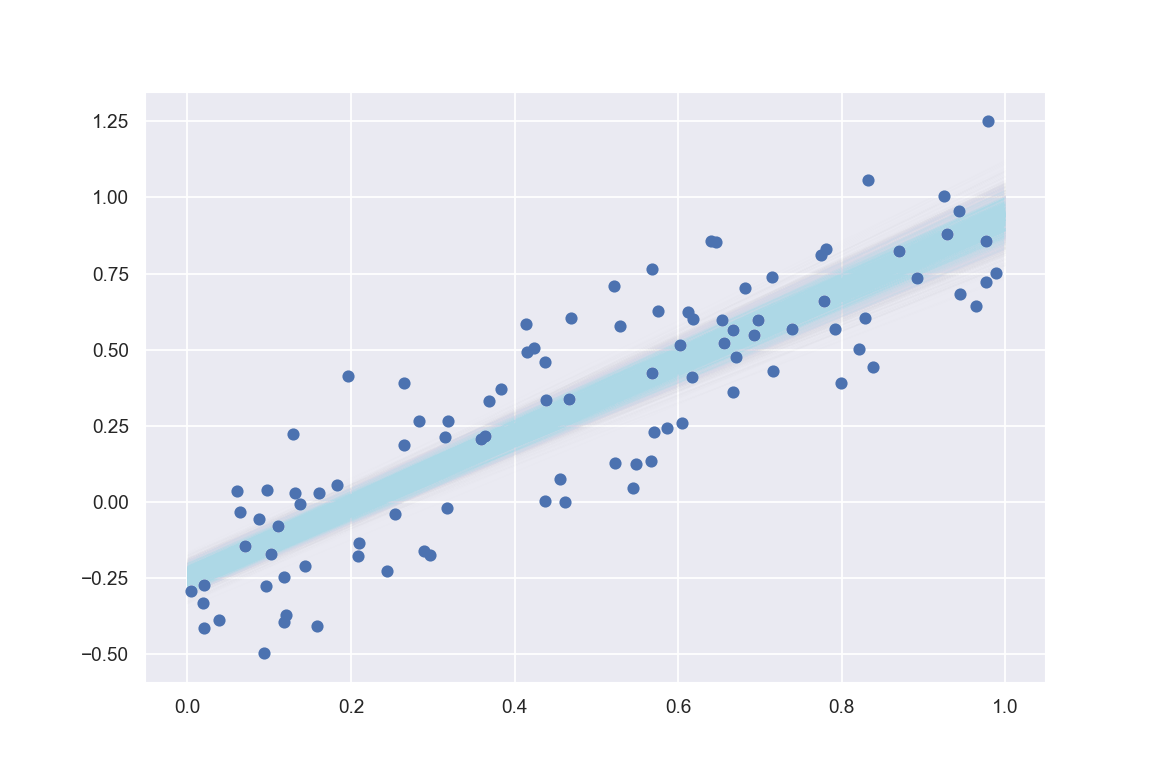

In [23]:
%matplotlib notebook
plt.scatter(X,y)
for w in lst_w:
    y_test = w.data[0].numpy()*X_test + w.data[1].numpy()
    plt.plot(X_test, y_test, alpha=0.005, linewidth=1, color='lightblue')

<IPython.core.display.Javascript object>


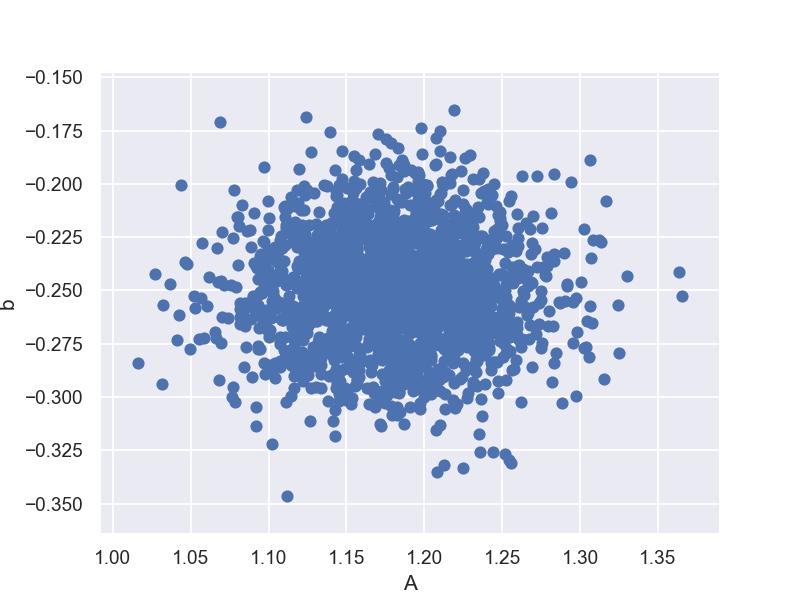

Text(0.5, 0, 'A')

In [21]:
%matplotlib notebook
W = torch.stack(lst_w)
plt.scatter(W[:,0].data, W[:,1].data)
plt.ylabel('b')
plt.xlabel('A')